In [1]:
import numpy as np
from hurst_fitting import *
from dukascopy_reader import Reader
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
LAGS = 15
START_DATE = datetime(2019,7,29)
END_DATE = datetime(2019,8,9)

In [4]:
reader = Reader(fname='CAC40.zip')

In [5]:
reader.load(START_DATE, END_DATE)
df = reader.df

In [6]:
df.head()

,Ask,AskVolume,Bid,BidVolume,Mid,Time
Time,,,,,,
2019-08-05 07:00:10.818,5310.569,0.0001,5309.569,0.0002,5310.069,2019-08-05 07:00:10.818
2019-08-05 07:00:10.957,5311.570,0.0001,5310.570,0.0001,5311.070,2019-08-05 07:00:10.957
2019-08-05 07:00:11.007,5313.069,0.0001,5312.069,0.0001,5312.569,2019-08-05 07:00:11.007
2019-08-05 07:00:11.931,5313.320,0.0001,5312.320,0.0001,5312.820,2019-08-05 07:00:11.931
2019-08-05 07:00:12.418,5314.069,0.0001,5313.069,0.0001,5313.569,2019-08-05 07:00:12.418


## Hurst index estimation at various sampling frequencies

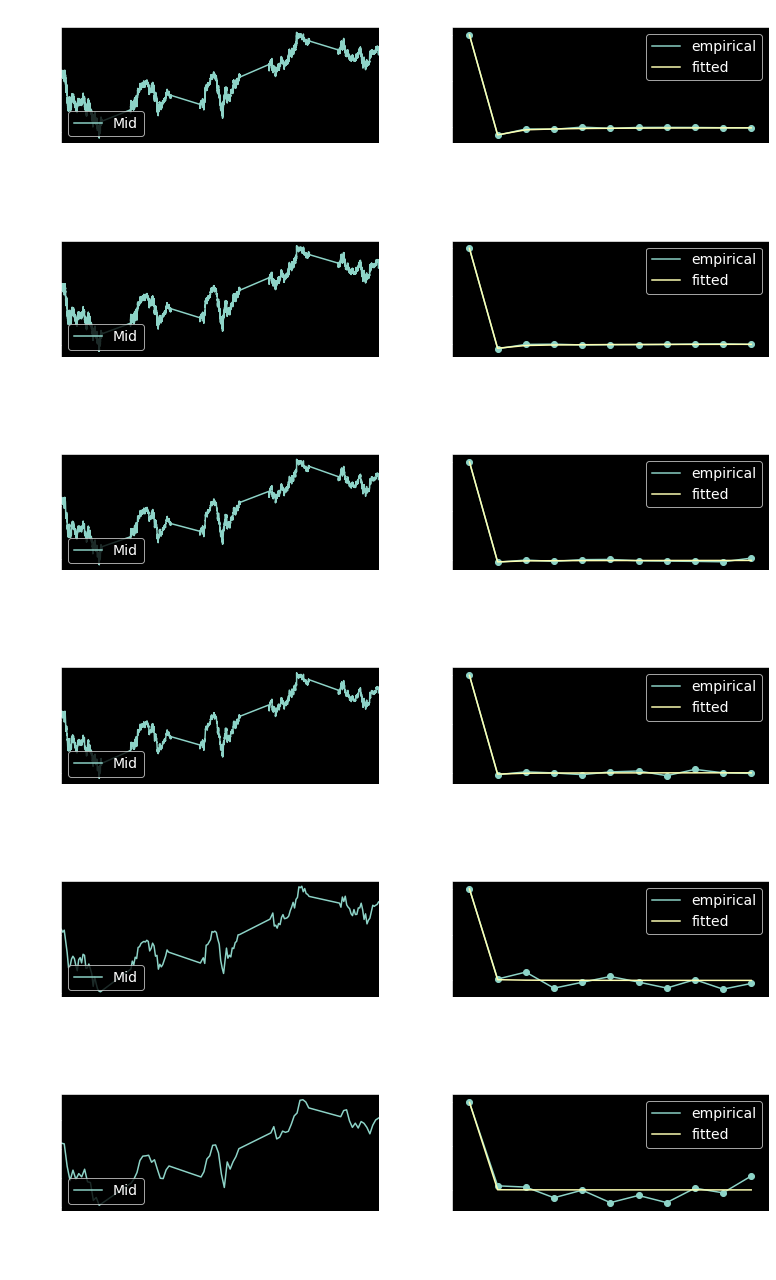

In [8]:
fig, axes = plt.subplots(nrows=6, ncols=2)

freqs = ['100ms', '1S', '30S', '1Min', '30Min', '1H']

fitter = Hurst_fitter(n_lags=LAGS)

for freq, ax_row in zip(freqs, axes):
    # dropna otherwise there will be gaps in the series because of non-market hours
    df_sampled = df['Mid'].resample(freq).first().dropna()
    
    ax = ax_row[0]
    df_sampled.plot(kind='line', ax=ax)
    ax.set_ylabel('price')
    ax.legend(loc='lower left')

    ax.set_title('{} sampling'.format(freq))

    fitter.df = df_sampled
    H_fit = fitter.fit()
    
    ax = ax_row[1]
    ys = acf(fitter.df_inc, nlags=LAGS)
    ys_fit = fitter.autocorr_frac_noise_range(H_fit)
    ax.plot(fitter.lag_range, ys, label='empirical')
    ax.scatter(fitter.lag_range, ys, marker='o')
    ax.plot(fitter.lag_range, ys_fit, label='fitted')
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.set_xlabel('H={:.2f} (fitted) '.format(H_fit))
    ax.set_ylabel('autocorrelogram')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper right')
    
plt.tight_layout()
plt.show()

## Conclusion
At high frequency, the price signal tends to mean-revert (negative autocorrelation of returns, fitted $H<0.5$).

At lower frequencies, it appears similar to a pure Browmian motion (no autocorrelation, no statistical arbitrage).